In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import cv2
import matplotlib.pyplot as plt
import contextlib
import os
import glob
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import pandas as pd
import matplotlib.patches as patches
from PIL import Image

In [2]:
# Cargar el modelo guardado
model = load_model("modelo_entrenado_2.h5", compile=False)

In [3]:
base_model = model.get_layer('model')  # Nombre del submodelo
layer_name="block7a_project_conv"
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 128, 128, 3)  0           ['normalization[0][0]']      

In [4]:
#función Expected Grad Cam
def expected_grad_cam(model, img_array, layer_name=layer_name):
    # Obtén el submodelo que contiene la capa `top_conv`
    base_model = model.get_layer('model')  # Nombre del submodelo
    grad_model = Model(inputs=base_model.input, outputs=[base_model.get_layer(layer_name).output, base_model.output])

    predictions = model.predict(img_array)
    num_classes = predictions.shape[-1]
    heatmap_shape = (img_array.shape[1], img_array.shape[2])
    expected_heatmap = np.zeros(heatmap_shape)

    for pred_index in range(num_classes):
        with tf.GradientTape() as tape:
            inputs = tf.cast(img_array, tf.float32)
            tape.watch(inputs)
            conv_outputs, predictions_for_class = grad_model(inputs)
            class_channel = predictions_for_class[:, pred_index]  # Mantén la conexión al grafo

        # Calcula los gradientes
        grads = tape.gradient(class_channel, conv_outputs)
        if grads is None:
            print(f"Gradientes no calculados para la clase {pred_index}")
            continue

        # Pondera los gradientes
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        pooled_grads = tf.reshape(pooled_grads, [1, 1, -1])

        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
        heatmap = tf.maximum(heatmap, 0)  # ReLU para mantener solo valores positivos

        if tf.reduce_max(heatmap) > 0:
            heatmap /= tf.reduce_max(heatmap)

        # Redimensiona el mapa de calor al tamaño de la imagen de entrada
        heatmap_resized = cv2.resize(heatmap.numpy(), (heatmap_shape[1], heatmap_shape[0]), interpolation=cv2.INTER_CUBIC)

        # Pondera el mapa de calor por la probabilidad de la clase
        prob = float(predictions[0, pred_index])
        expected_heatmap += heatmap_resized * prob

    # Recorta los valores para mantenerlos entre 0 y 1
    expected_heatmap = np.clip(expected_heatmap, 0, 1)
    return expected_heatmap

In [5]:
# Función Grad-CAM 
def grad_cam(model, img_array, layer_name, pred_index):
    # Obtener el submodelo que contiene las capas convolucionales
    base_model = model.get_layer('model')
    # Crear un modelo que tenga como entrada la entrada del submodelo base y salida de la capa interna
    grad_model = Model(inputs=base_model.input, # Entrada del submodelo base
                       outputs=[base_model.get_layer(layer_name).output, base_model.output]) # Acceso directo a la capa del modelo
    
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        class_channel = predictions[:, pred_index]  # Seleccionar el canal de la clase correspondiente

    grads = tape.gradient(class_channel, conv_outputs) # Obtener los gradientes de la clase predicha con respecto a la salida de la capa de convolución
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # Calcular el promedio de los gradientes en cada canal
    # Ponderar la salida de la convolución con los gradientes promedio
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) # Aplicar ReLU para eliminar valores negativos

    if tf.math.reduce_max(heatmap) > 0:
        heatmap /= tf.math.reduce_max(heatmap)

    return np.clip(heatmap, 0, 1) # Devolver las dimensiones de la capa

In [6]:
# Función Grad-CAM++
def grad_cam_plus_plus(model, img_array, layer_name, pred_index):
    # Obtener el submodelo que contiene las capas convolucionales
    base_model = model.get_layer('model')
    # Crear un modelo que tenga como entrada la entrada del submodelo base y salida de la capa interna
    grad_model = Model(inputs=base_model.input, # Entrada del submodelo base
                       outputs=[base_model.get_layer(layer_name).output, base_model.output]) # Acceso directo a la capa del modelo

    with tf.GradientTape(persistent=True) as tape:
        inputs = tf.cast(img_array, tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        class_channel = predictions[:, pred_index] # Seleccionar el canal de la clase correspondiente
        tape.watch(conv_outputs)

        # Gradientes de primer, segundo y tercer orden
        grads = tape.gradient(class_channel, conv_outputs) # Obtener los gradientes de la clase predicha con respecto a la salida de la capa de convolución
        second_grads = tape.gradient(grads, conv_outputs) 
        third_grads = tape.gradient(second_grads, conv_outputs)

    # Cálculo de alphas y pesos
    first_grads = tf.maximum(grads, 0)
    alpha_num = second_grads
    alpha_denom = 2 * second_grads + third_grads * tf.reduce_sum(conv_outputs, axis=(0, 1, 2))
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * first_grads, axis=(0, 1))

    # Construir el mapa de activación
    conv_outputs = conv_outputs[0]
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    weights = tf.reshape(weights, [-1])  # Asegurarse de que sea un vector 1D

    for i in range(conv_outputs.shape[-1]):
        cam += weights[i] * conv_outputs[:, :, i]

    # Normalizar el mapa de calor
    cam = np.maximum(cam, 0)
    cam = 1 - cam  # Invertir el mapa de calor
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    if cam.max() != cam.min():
        cam = (cam - cam.min()) / (cam.max() - cam.min())
    else:
        cam = np.zeros_like(cam)
    return cam

In [7]:
def mostrar_hallazgos_con_ajuste(image_path, registros, escala):
    # Cargar la imagen
    imagen = Image.open(image_path)
    img_width, img_height = imagen.size
    
    # Configurar el tamaño de la figura para reducir el tamaño de la imagen
    dpi = 100  # Densidad de píxeles por pulgada
    fig, ax = plt.subplots(1, figsize=(img_width / (dpi * escala), img_height / (dpi * escala)), dpi=dpi)
    ax.imshow(imagen, cmap="gray")

    # Lista para almacenar los detalles de cada hallazgo
    detalles_hallazgos = []

    for idx, (index, registro) in enumerate(registros.iterrows(), start=1):
        # Verificar si las coordenadas son válidas
        if pd.isna(registro['xmin']) or pd.isna(registro['ymin']) or pd.isna(registro['xmax']) or pd.isna(registro['ymax']):
            print(f"Las coordenadas de la anotación están incompletas para el hallazgo {idx} y serán omitidas.")
            continue

        # Obtener datos del registro y dimensiones originales
        breast_birads = registro['finding_birads']
        breast_density = registro.get('breast_density', 'N/A')
        finding_categories = registro.get('finding_categories', 'N/A')
        xmin = int(registro['xmin'])
        ymin = int(registro['ymin'])
        xmax = int(registro['xmax'])
        ymax = int(registro['ymax'])
        original_height = registro['height']
        original_width = registro['width']
        
        # Escalado de las coordenadas en base a las dimensiones de la imagen
        scale_x = img_width / original_width
        scale_y = img_height / original_height
        
        # Ajustar las coordenadas de acuerdo a la escala calculada
        xmin = int(xmin * scale_x)
        ymin = int(ymin * scale_y)
        xmax = int(xmax * scale_x)
        ymax = int(ymax * scale_y)

        # Crear el cuadro delimitador en color rojo con grosor
        ancho = xmax - xmin
        alto = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), ancho, alto, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Calcular la posición central superior para el número del hallazgo
        center_x = xmin + ancho / 2
        text_y = ymin - 10  # Ajustar el texto ligeramente arriba de ymin
        
        # Añadir el número de hallazgo en el cuadro, centrado en la parte superior
        ax.text(center_x, text_y, f"{idx}", color="white", fontsize=12, weight="bold", 
                ha="center", bbox=dict(facecolor='red', edgecolor='none', boxstyle="round,pad=0.3"))

        # Agregar detalles a la lista para la tabla
        detalles_hallazgos.append([idx, breast_density, finding_categories, breast_birads])

    plt.axis("off") 
    # Mostrar la imagen con los cuadros y la numeración de los hallazgos
    plt.show()

    # Crear un DataFrame para mostrar los detalles de los hallazgos
    col_labels = ["# Hallazgo", "Densidad Mamaria", "Categorías de Hallazgo", "BI-RADS"]
    detalles_df = pd.DataFrame(detalles_hallazgos, columns=col_labels)

    # Mostrar el DataFrame como una tabla sin índice en el entorno Jupyter Notebook
    from IPython.display import HTML, display
    display(HTML(detalles_df.to_html(index=False)))

In [8]:
# Aplicar Grad-CAM en cada fragmento y generar un mapa de calor
def apply_heatmap_on_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, 1-alpha, heatmap, alpha, 0)
    return superimposed_img

In [9]:
# Función para calcular la entropía de las predicciones
def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities + 1e-10))

In [10]:
def visualize_all_gradcam_methods(model, image_path, layer_name=layer_name):
    # Crear una carpeta temporal para contener la imagen
    temp_dir = './temp_dir'
    os.makedirs(temp_dir + '/temp', exist_ok=True)

    # Copiar la imagen a la carpeta temporal
    imagen_copiada = os.path.join(temp_dir + '/temp', os.path.basename(image_path))
    shutil.copy(image_path, imagen_copiada)

    # Crear el generador de datos
    datagen = ImageDataGenerator()

    # Configurar el generador de prueba
    prueba_generator = datagen.flow_from_directory(
        directory=temp_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode=None,
        color_mode='rgb',
        shuffle=False
    )

    for img_array in prueba_generator:
        # Nombres de las clases 
        class_names = ['Hallazgo', 'Sin Hallazgo']
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]

        # Calcular la entropía de la predicción
        entropy = calculate_entropy(predictions[0])
        
        # Obtener los mapas de calor
        expected_heatmap = 1 - expected_grad_cam(model, img_array, layer_name)
        grad_cam_heatmap = 1 - grad_cam(model, img_array, layer_name, predicted_class)
        grad_cam_plus_plus_heatmap = 1 - grad_cam_plus_plus(model, img_array, layer_name, predicted_class)
        
        # Preparar las imágenes superpuestas
        img = (img_array[0] * 255).astype(np.uint8)  # Desescalar para mostrar correctamente
        original_img = img.copy()  # Imagen original
        grad_cam_plus_plus_img = apply_heatmap_on_image(img, grad_cam_plus_plus_heatmap)
        expected_img = apply_heatmap_on_image(img, expected_heatmap)
        grad_cam_img = apply_heatmap_on_image(img, grad_cam_heatmap)

        # Crear la figura con 4 imágenes y barra de color
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Figura 2x2
        titles = ['Original', 'Grad-CAM++', 'Expected Grad-CAM', 'Grad-CAM']
        images = [original_img, grad_cam_plus_plus_img, expected_img, grad_cam_img]

        # Añadir cada imagen a la figura
        for ax, img, title in zip(axs.flat, images, titles):
            im = ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(title, fontsize=14, fontweight='bold')

        # Añadir barra de calor común
        cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Barra vertical ajustada a la figura
        plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), cax=cbar_ax)

        # Añadir texto con las métricas
        title_text = 'Resultados'
        metrics_text = (f'Clase predicha: {class_names[predicted_class]}\n'
                        f'Probabilidad: {confidence * 100:.2f}%\n'
                        f'Entropía: {entropy * 100:.2f}%')
        
        # Añadir texto debajo de la figura
        plt.figtext(0.5, 0.07, title_text, ha="center", va="top", fontsize=16, weight='bold', bbox={"facecolor": "lightgray", "alpha": 0})
        plt.figtext(0.5, 0.04, metrics_text, ha="center", va="top", fontsize=14, bbox={"facecolor": "lightgray", "alpha": 0})
        
        # Ajustar márgenes de la figura
        fig.subplots_adjust(top=0.9, right=0.9, wspace=0.1, hspace=0.1)

        plt.show()
        break  # Salir después de la primera imagen

    # Limpiar la carpeta temporal
    shutil.rmtree(temp_dir)

In [11]:
# Función para aplicar el texto con la clase en la imagen con fondo semitransparente
def add_text_to_image(image, text, position=(10, 30), font_scale=0.6, color=(255, 255, 255), thickness=1):
    font = cv2.FONT_HERSHEY_SIMPLEX
    return cv2.putText(image, text, position, font, font_scale, color, thickness, cv2.LINE_AA)

# Función para suprimir la salida de la consola
@contextlib.contextmanager
def suppress_stdout():
    original_stdout = sys.stdout  # Guardar el valor de sys.stdout
    sys.stdout = open(os.devnull, 'w')  # Redirigir sys.stdout a null
    try:
        yield
    finally:
        sys.stdout.close()  # Cerrar el archivo temporal
        sys.stdout = original_stdout  # Restaurar sys.stdout

def visualize_combined_methods(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name=layer_name):
    methods = {
        'Expected Grad-CAM': expected_grad_cam,
        'Grad-CAM': grad_cam,
        'Grad-CAM++': grad_cam_plus_plus
    }
    combined_images = []  # Almacenar las imágenes finales para cada método

    for method_name, grad_method in methods.items():
        def process_and_visualize_for_method(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name, grad_method):
            final_image = np.zeros((fragment_size[0] * num_rows, fragment_size[1] * num_cols, 3), dtype=np.uint8)

            for i, num in enumerate(range(1, num_rows * num_cols + 1)):
                fragment_paths = glob.glob(os.path.join(fragment_dir, f'*_{num}.png'))
                if not fragment_paths:
                    continue
                fragment_path = fragment_paths[0]

                # Crear carpeta temporal
                temp_dir = './temp_dir'
                os.makedirs(temp_dir + '/temp', exist_ok=True)

                # Copiar imagen al directorio temporal
                imagen_copiada = os.path.join(temp_dir + '/temp', os.path.basename(fragment_path))
                shutil.copy(fragment_path, imagen_copiada)

                # Crear generador de datos
                datagen = ImageDataGenerator()

                with suppress_stdout():
                    prueba_generator = datagen.flow_from_directory(
                        directory=temp_dir,
                        target_size=fragment_size,
                        batch_size=32,
                        class_mode=None,
                        color_mode='rgb',
                        shuffle=False
                    )

                for img_array in prueba_generator:
                    predictions = model.predict(img_array, verbose=0)
                    prediction_percentages = (predictions[0] * 100).round(0)

                    # Determinar la clase con mayor probabilidad
                    predicted_class = np.argmax(predictions[0])
                    # Texto de las predicciones
                    class_text = f'[{prediction_percentages[0]:.0f}%, {prediction_percentages[1]:.0f}%]'

                    # Generar imagen con o sin mapa de calor según la probabilidad dominante
                    img = (img_array[0] * 255).astype(np.uint8)

                    if predicted_class == 0:  # Clase "hallazgo"
                        if grad_method == expected_grad_cam:
                            with suppress_stdout():
                                heatmap = grad_method(model, img_array, layer_name=layer_name)  # Sin pred_index
                        else:
                            heatmap = grad_method(model, img_array, layer_name=layer_name, pred_index=predicted_class)  # Con pred_index
                        heatmap = 1 - heatmap
                        superimposed_img = apply_heatmap_on_image(img, heatmap)
                    else:  # Clase "sin hallazgo"
                        superimposed_img = img.copy()

                    # Añadir texto de predicción a la imagen
                    superimposed_img = add_text_to_image(superimposed_img, class_text)

                    # Insertar el fragmento en la posición correspondiente
                    row = i // num_cols
                    col = i % num_cols
                    final_image[row * fragment_size[0]:(row + 1) * fragment_size[0],
                                col * fragment_size[1]:(col + 1) * fragment_size[1]] = superimposed_img
                    break

                # Limpiar carpeta temporal
                shutil.rmtree(temp_dir)

            return final_image

        # Procesar fragmentos para el método actual
        final_image = process_and_visualize_for_method(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name, grad_method)
        combined_images.append(final_image)
        
    return combined_images

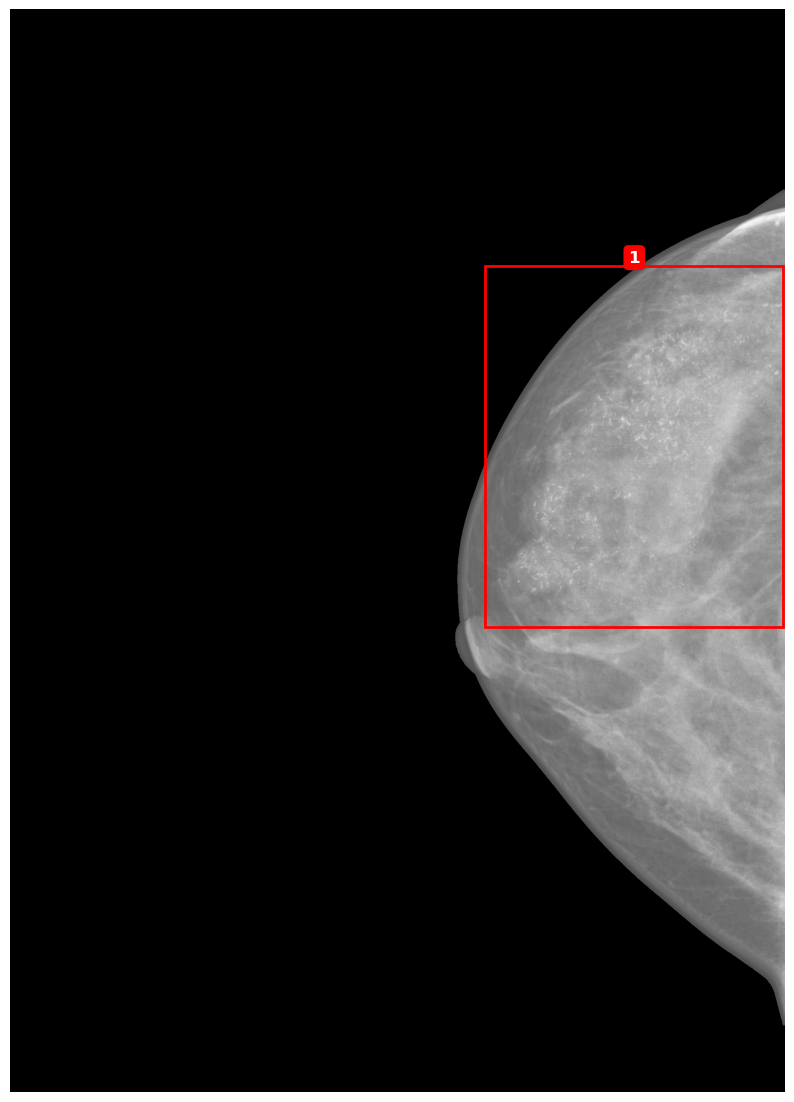

In [12]:
# Cargar el archivo de anotaciones
finding_annotations_path = "./finding_annotations.csv"
finding_annotations_df = pd.read_csv(finding_annotations_path)

# Definir el ID de la imagen a visualizar
image_id = "0f37159abdcef6a062e404df47e8f1ac"  # ID de la imagen
image_path = f"./4_dataset_negativo/{image_id}.png"  # Ruta de la imagen

# Filtrar todos los registros correspondientes al `image_id` especificado
registros = finding_annotations_df[finding_annotations_df['image_id'] == image_id]

# Llamar a la función para visualizar con ajuste de escala (por ejemplo, reducir tamaño a la mitad)
mostrar_hallazgos_con_ajuste(image_path, registros, escala=2)

# **Fragmento región de Hallazgo**

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 16ms/step


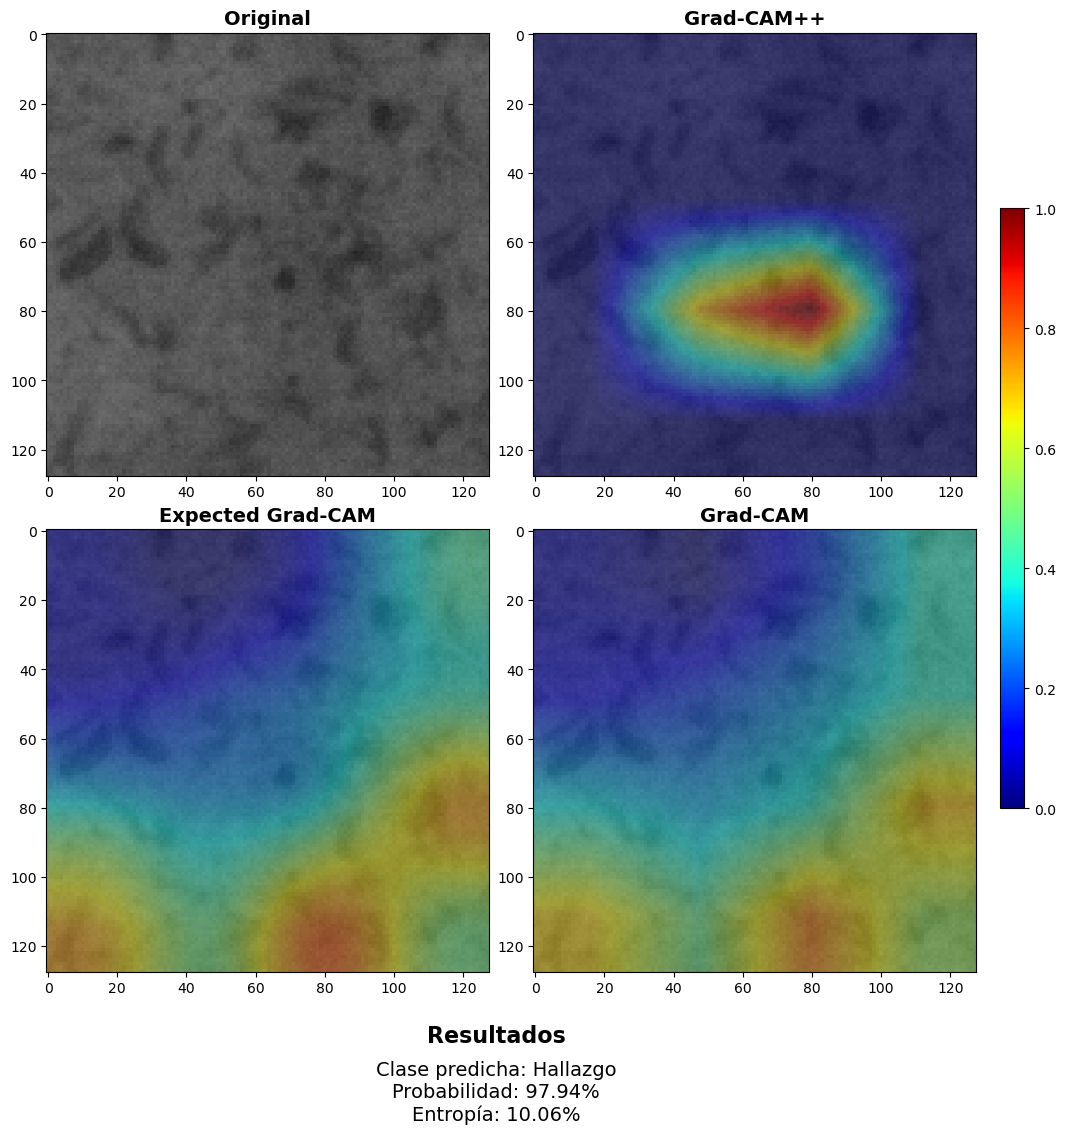

In [13]:
# Ruta de la imagen
image_path = r"fragmentos/0f37159abdcef6a062e404df47e8f1ac_1_BI-RADS_4_22.png"

# Llamar a la función para visualizar
visualize_all_gradcam_methods(model, image_path)

# **Región de Hallazgo**

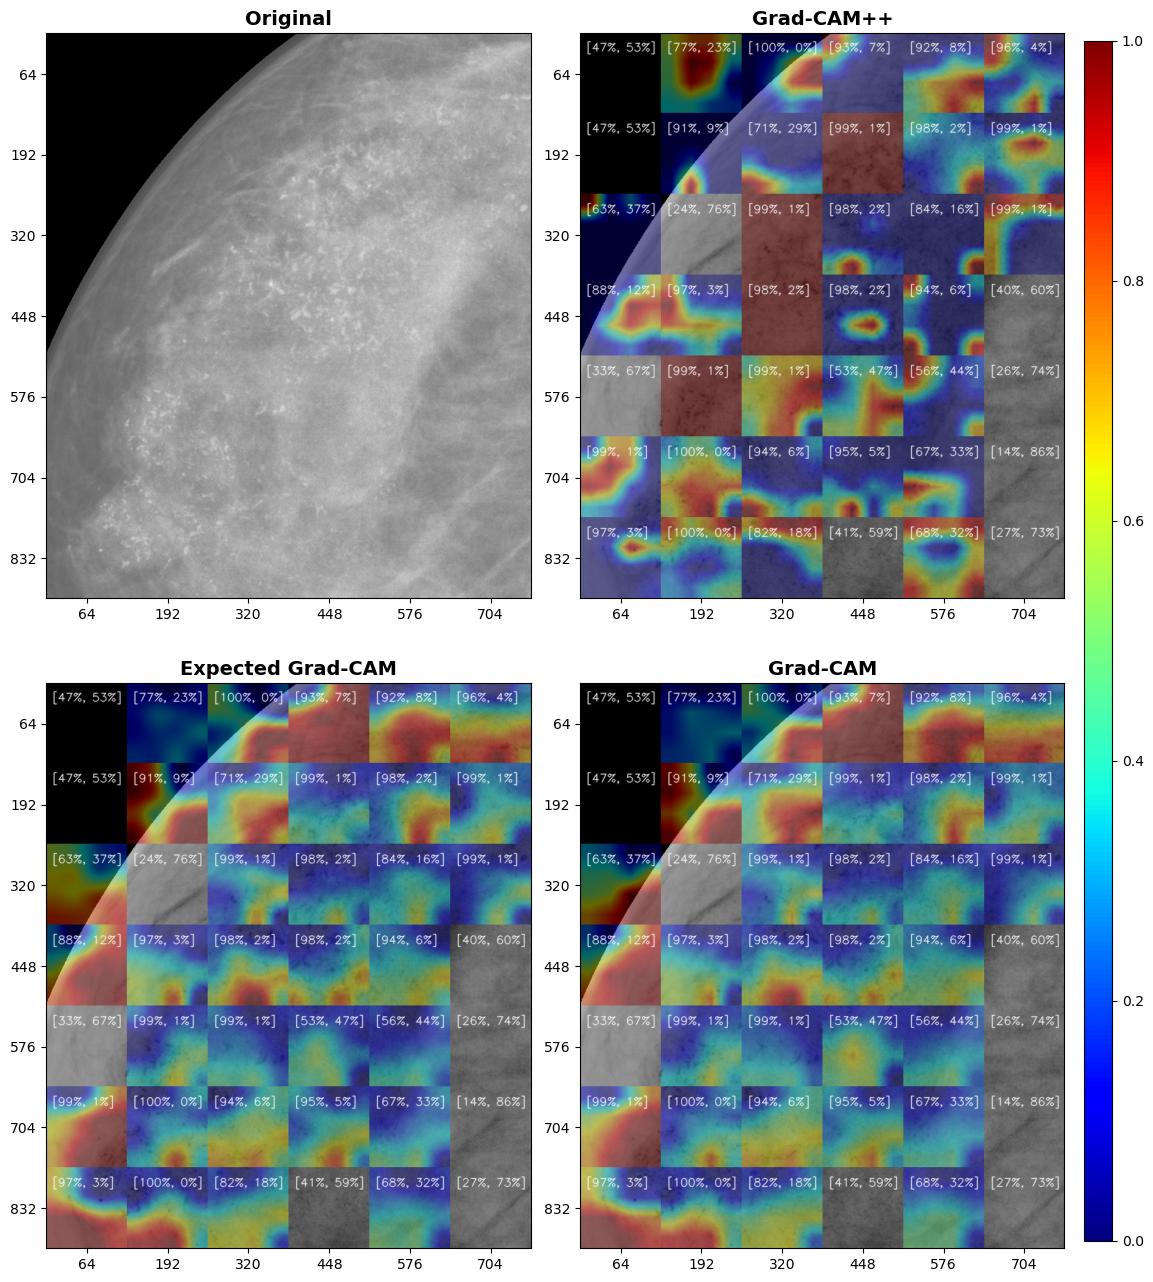

In [14]:
def visualize_combined_images_with_original_and_heatmaps(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name=layer_name):
    # Generar la imagen original combinada
    original_image = unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=True)

    # Generar imágenes combinadas usando Grad-CAM métodos
    combined_images = visualize_combined_methods(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name)

    # Crear figura con 2x2 para mostrar todas las imágenes
    fig, axs = plt.subplots(2, 2, figsize=(14, 15))  # Figura 2x2
    titles = ['Original', 'Grad-CAM++', 'Expected Grad-CAM', 'Grad-CAM']
    images = [original_image, combined_images[2], combined_images[0], combined_images[1]]  # Orden de imágenes

    # Añadir cada imagen a la figura
    for ax, img, title in zip(axs.flat, images, titles):
        im = ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        # Configurar los ticks de los ejes
        img_height, img_width, _ = img.shape
        x_ticks = np.arange(64, img_width, 128)
        y_ticks = np.arange(64, img_height, 128)

        # Asegurarse de incluir marcas en 64 si no están
        if img_width >= 64 and 64 not in x_ticks:
            x_ticks = np.append(64, x_ticks)
        if img_height >= 64 and 64 not in y_ticks:
            y_ticks = np.append(64, y_ticks)

        # Aplicar los ticks a los ejes
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.axis("on")  # Mantener los ejes visibles

    # Añadir barra de calor común para los mapas de Grad-CAM
    cbar_ax = fig.add_axes([0.88, 0.115, 0.02, 0.8])  # Barra vertical ajustada
    plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), cax=cbar_ax)

    # Ajustar márgenes de la figura
    fig.subplots_adjust(top=0.92, right=0.88, wspace=0.02, hspace=0.15)
    
    plt.show()

# Modificar la función `unir_fragmentos_y_mostrar` para devolver la imagen en lugar de mostrarla
def unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=False):
    # Crear una imagen vacía para la imagen final
    final_image = np.zeros((fragment_size[0] * num_rows, fragment_size[1] * num_cols, 3), dtype=np.uint8)
    
    # Iterar sobre los fragmentos y colocarlos en la imagen final
    for i, num in enumerate(range(1, num_rows * num_cols + 1)):
        # Buscar el archivo correspondiente al fragmento
        fragment_path = os.path.join(fragment_dir, f"0f37159abdcef6a062e404df47e8f1ac_1_BI-RADS_4_{num}.png")
        if not os.path.exists(fragment_path):
            print(f"Fragmento {num} no encontrado. Se omitirá.")
            continue

        # Leer el fragmento
        fragment = cv2.imread(fragment_path)
        if fragment is None:
            print(f"Error al cargar el fragmento {num}. Se omitirá.")
            continue

        # Redimensionar el fragmento para asegurar consistencia
        fragment = cv2.resize(fragment, (fragment_size[1], fragment_size[0]))

        # Calcular la posición en la imagen final
        row = i // num_cols
        col = i % num_cols
        y_start = row * fragment_size[0]
        y_end = y_start + fragment_size[0]
        x_start = col * fragment_size[1]
        x_end = x_start + fragment_size[1]

        # Colocar el fragmento en la posición correspondiente
        final_image[y_start:y_end, x_start:x_end] = fragment

    if return_image:
        return final_image
    else:
        # Mostrar la imagen final
        plt.figure(figsize=(28, 16))
        plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
        plt.title("Original", fontsize=25, fontweight='bold')
        plt.axis("on")
        plt.show()

# Parámetros de ejemplo
fragment_dir = 'fragmentos'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 7  # Define el número de filas en la imagen final
num_cols = 6  # Define el número de columnas en la imagen final

# Visualizar las imágenes combinadas con el modelo y métodos Grad-CAM
visualize_combined_images_with_original_and_heatmaps(model, fragment_dir, fragment_size, num_rows, num_cols)

# **Mamografía sin manipular**

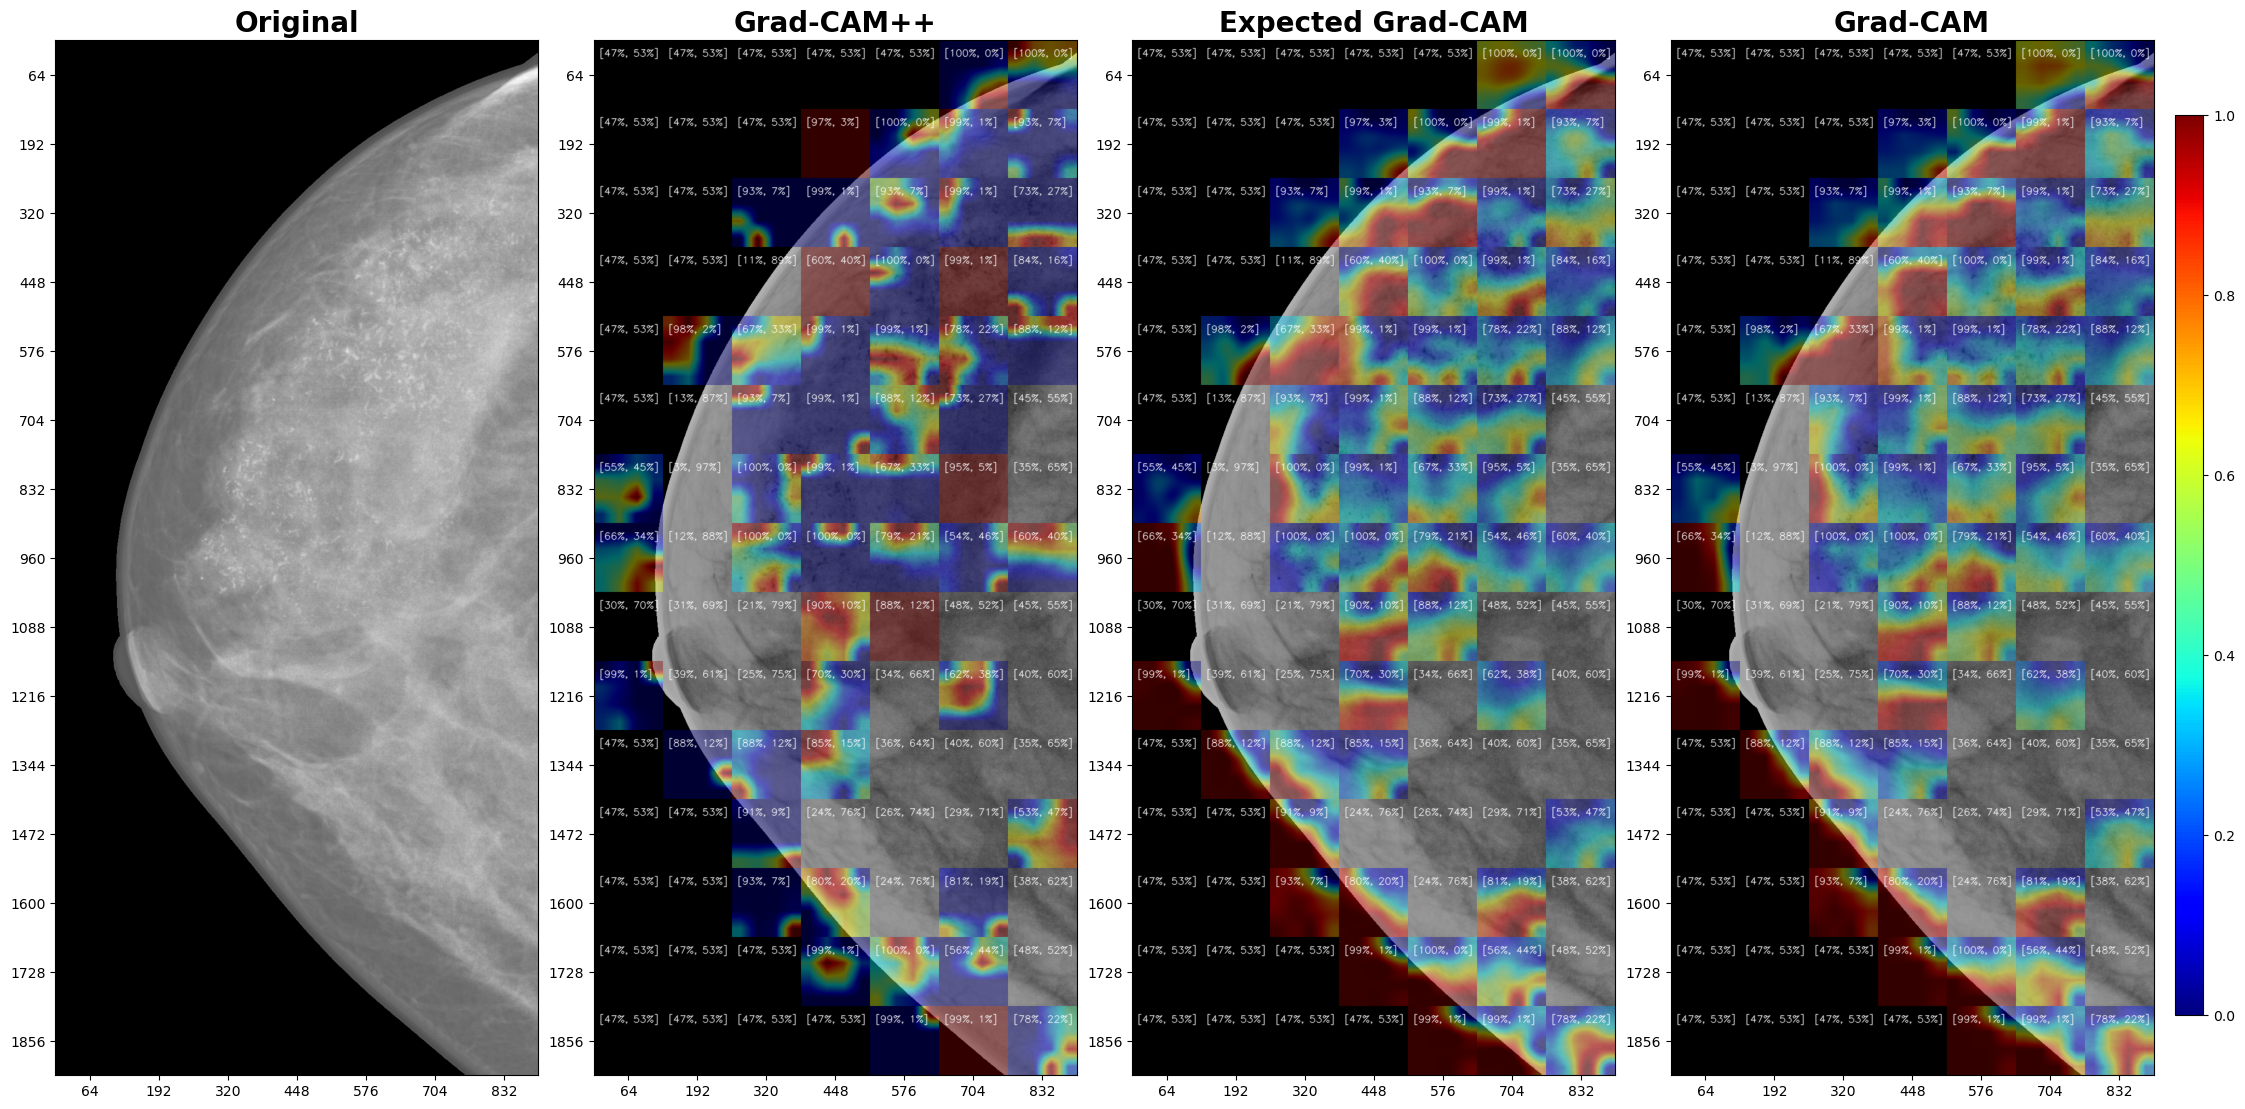

In [15]:
def visualize_combined_images_horizontal(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name=layer_name):
    # Generar la imagen original combinada
    original_image = unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=True)

    # Generar imágenes combinadas usando Grad-CAM métodos
    combined_images = visualize_combined_methods(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name)

    # Crear figura con 1x4 para mostrar todas las imágenes horizontalmente
    fig, axs = plt.subplots(1, 4, figsize=(28, 15))  # Figura 1x4
    titles = ['Original', 'Grad-CAM++', 'Expected Grad-CAM', 'Grad-CAM']
    # Reordenar las imágenes según la secuencia requerida
    images = [original_image, combined_images[2], combined_images[0], combined_images[1]]

    # Añadir cada imagen a la figura
    for ax, img, title in zip(axs, images, titles):
        im = ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title, fontsize=20, fontweight='bold')
        
        # Configurar los ticks de los ejes
        img_height, img_width, _ = img.shape
        x_ticks = np.arange(64, img_width, 128)
        y_ticks = np.arange(64, img_height, 128)

        # Asegurarse de incluir marcas en 64 si no están
        if img_width >= 64 and 64 not in x_ticks:
            x_ticks = np.append(64, x_ticks)
        if img_height >= 64 and 64 not in y_ticks:
            y_ticks = np.append(64, y_ticks)

        # Aplicar los ticks a los ejes
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.axis("on")  # Mantener los ejes visibles

    # Añadir barra de calor común para los mapas de Grad-CAM
    cbar_ax = fig.add_axes([0.885, 0.15, 0.01, 0.6])  # Barra vertical ajustada
    plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), cax=cbar_ax)

    # Ajustar márgenes de la figura
    fig.subplots_adjust(top=0.8, right=0.88, wspace=0.08)
    
    plt.show()

# Modificar la función `unir_fragmentos_y_mostrar` para devolver la imagen en lugar de mostrarla
def unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=False):
    # Crear una imagen vacía para la imagen final
    final_image = np.zeros((fragment_size[0] * num_rows, fragment_size[1] * num_cols, 3), dtype=np.uint8)
    
    # Iterar sobre los fragmentos y colocarlos en la imagen final
    for i, num in enumerate(range(1, num_rows * num_cols + 1)):
        # Buscar el archivo correspondiente al fragmento
        fragment_path = os.path.join(fragment_dir, f"0f37159abdcef6a062e404df47e8f1ac_{num}.png")
        if not os.path.exists(fragment_path):
            print(f"Fragmento {num} no encontrado. Se omitirá.")
            continue

        # Leer el fragmento
        fragment = cv2.imread(fragment_path)
        if fragment is None:
            print(f"Error al cargar el fragmento {num}. Se omitirá.")
            continue

        # Redimensionar el fragmento para asegurar consistencia
        fragment = cv2.resize(fragment, (fragment_size[1], fragment_size[0]))

        # Calcular la posición en la imagen final
        row = i // num_cols
        col = i % num_cols
        y_start = row * fragment_size[0]
        y_end = y_start + fragment_size[0]
        x_start = col * fragment_size[1]
        x_end = x_start + fragment_size[1]

        # Colocar el fragmento en la posición correspondiente
        final_image[y_start:y_end, x_start:x_end] = fragment

    if return_image:
        return final_image
    else:
        # Mostrar la imagen final
        plt.figure(figsize=(34, 34))
        plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
        plt.title("Original", fontsize=25, fontweight='bold')
        plt.axis("on")
        plt.show()

# Parámetros de ejemplo
fragment_dir = 'fragmentos_1'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 15  # Define el número de filas en la imagen final
num_cols = 7  # Define el número de columnas en la imagen final

# Visualizar las imágenes combinadas horizontalmente
visualize_combined_images_horizontal(model, fragment_dir, fragment_size, num_rows, num_cols)

# **Mamografía manipulada**

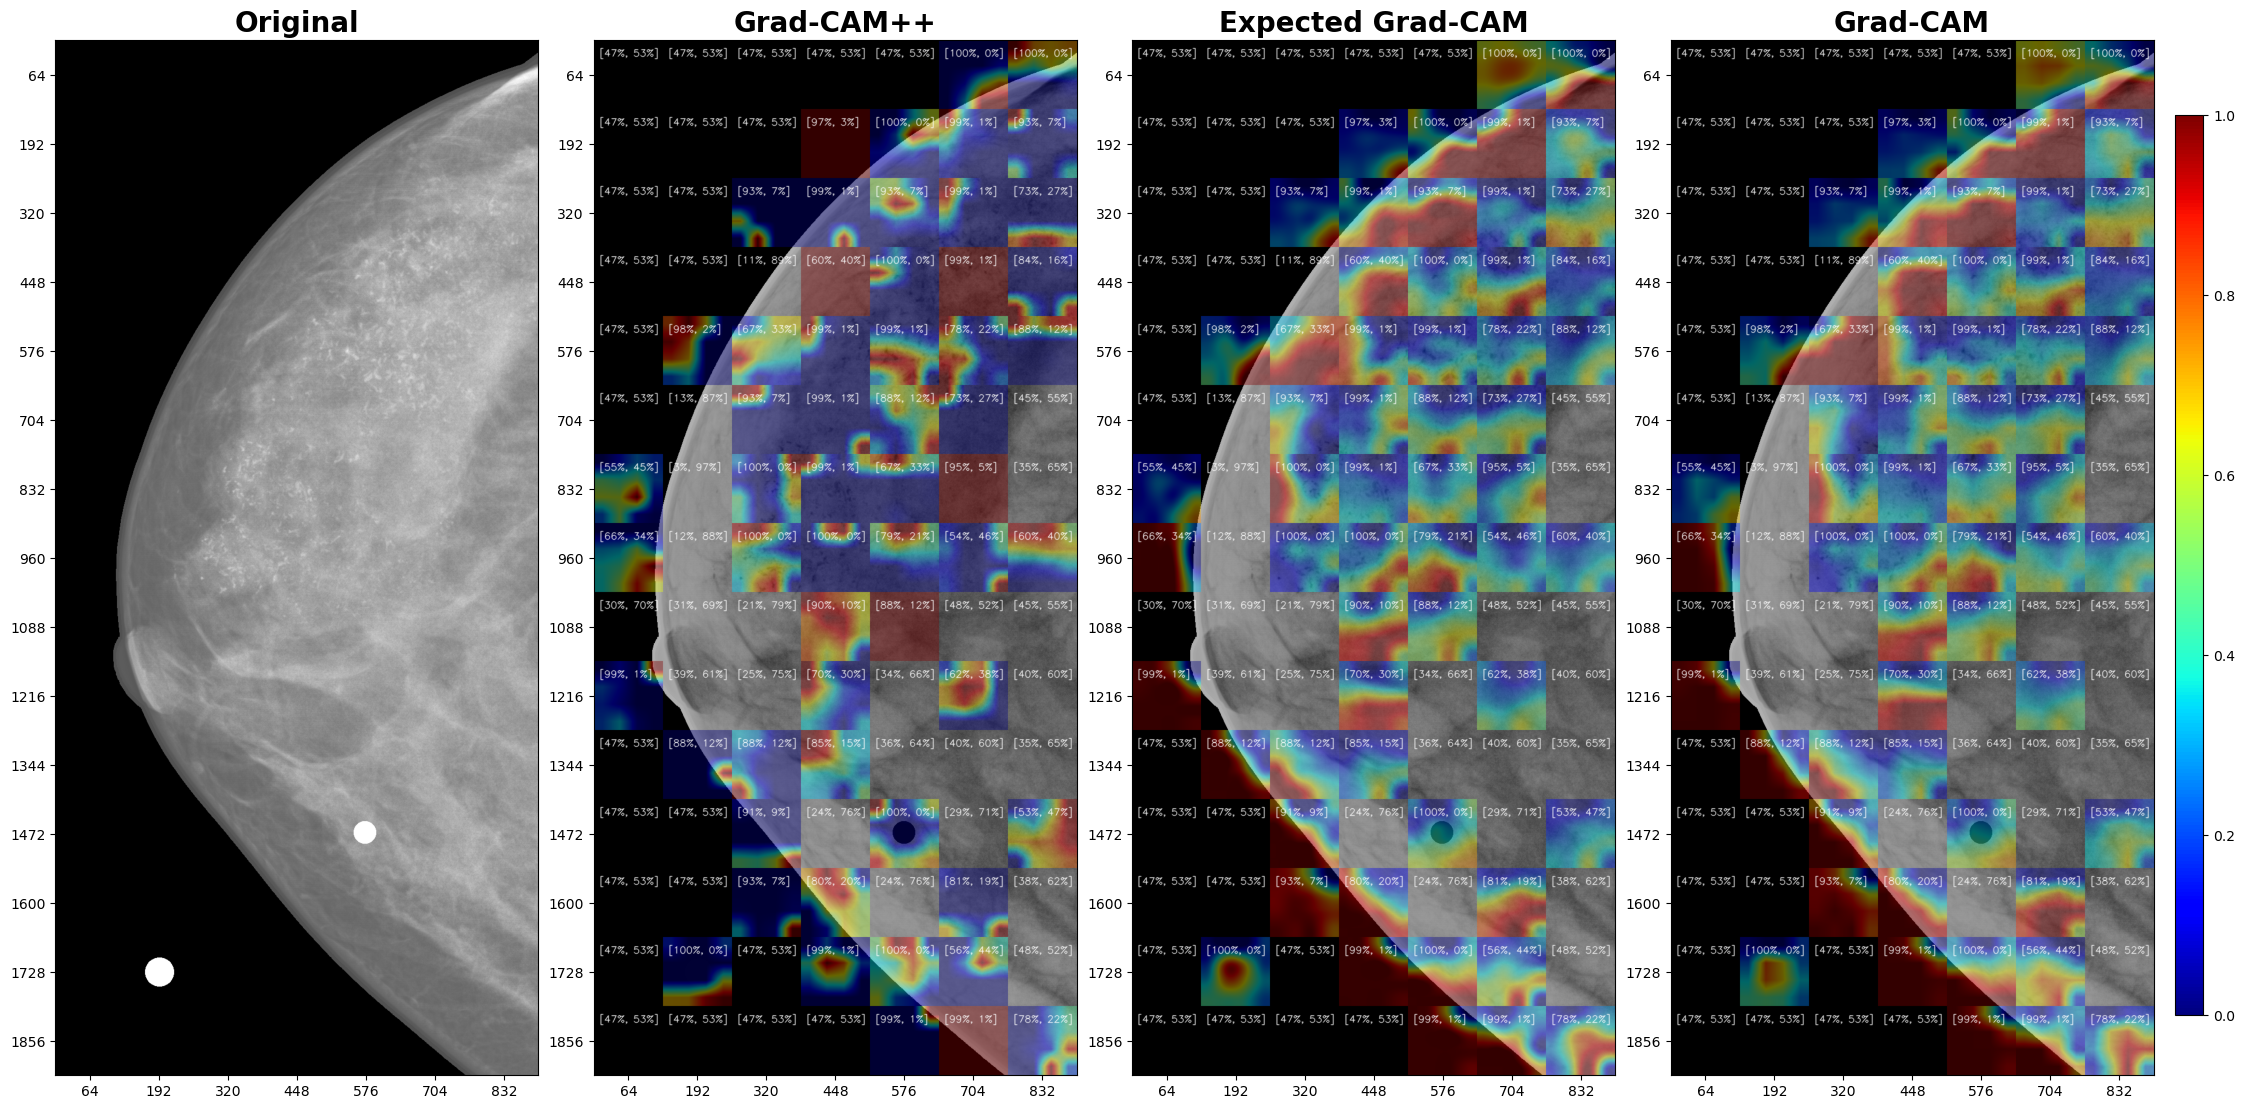

In [16]:
# Modificar la función `unir_fragmentos_y_mostrar` para devolver la imagen en lugar de mostrarla
def unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=False):
    # Crear una imagen vacía para la imagen final
    final_image = np.zeros((fragment_size[0] * num_rows, fragment_size[1] * num_cols, 3), dtype=np.uint8)
    
    # Iterar sobre los fragmentos y colocarlos en la imagen final
    for i, num in enumerate(range(1, num_rows * num_cols + 1)):
        # Buscar el archivo correspondiente al fragmento
        fragment_path = os.path.join(fragment_dir, f"0f37159abdcef6a062e404df47e8f1ac_{num}.png")
        if not os.path.exists(fragment_path):
            print(f"Fragmento {num} no encontrado. Se omitirá.")
            continue

        # Leer el fragmento
        fragment = cv2.imread(fragment_path)
        if fragment is None:
            print(f"Error al cargar el fragmento {num}. Se omitirá.")
            continue

        # Redimensionar el fragmento para asegurar consistencia
        fragment = cv2.resize(fragment, (fragment_size[1], fragment_size[0]))

        # Calcular la posición en la imagen final
        row = i // num_cols
        col = i % num_cols
        y_start = row * fragment_size[0]
        y_end = y_start + fragment_size[0]
        x_start = col * fragment_size[1]
        x_end = x_start + fragment_size[1]

        # Colocar el fragmento en la posición correspondiente
        final_image[y_start:y_end, x_start:x_end] = fragment

    if return_image:
        return final_image
    else:
        # Mostrar la imagen final
        plt.figure(figsize=(34, 34))
        plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
        plt.title("Original", fontsize=25, fontweight='bold')
        plt.axis("on")
        plt.show()

# Parámetros de ejemplo
fragment_dir = 'fragmentos_2'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 15  # Define el número de filas en la imagen final
num_cols = 7  # Define el número de columnas en la imagen final

# Visualizar las imágenes combinadas horizontalmente
visualize_combined_images_horizontal(model, fragment_dir, fragment_size, num_rows, num_cols)

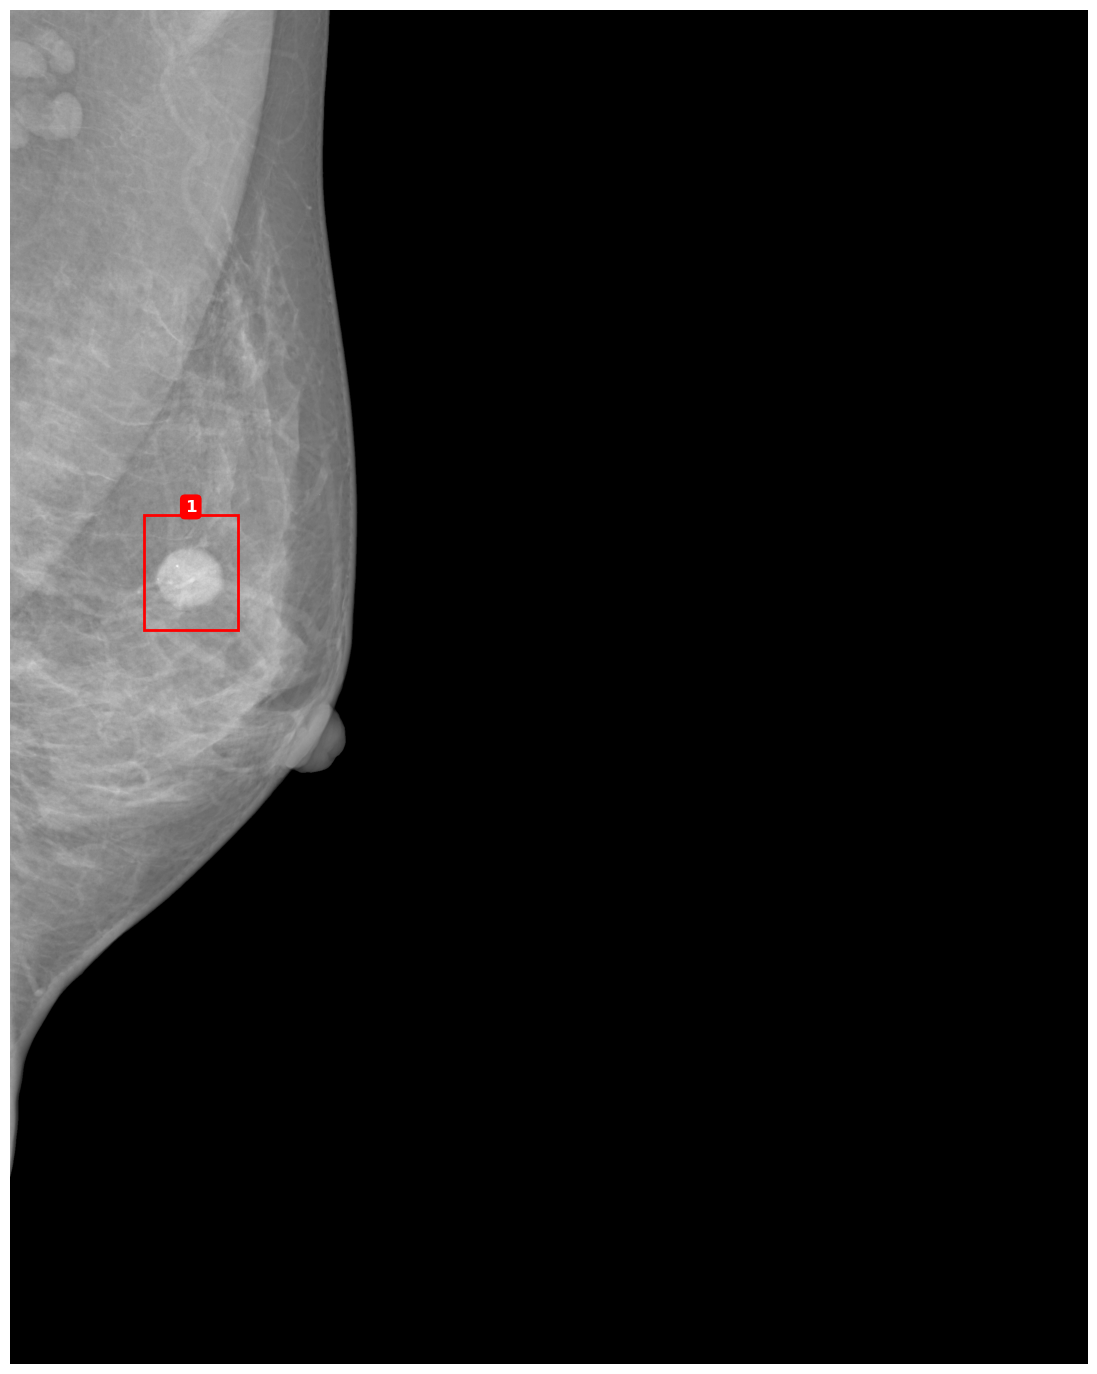

In [17]:
# Cargar el archivo de anotaciones
finding_annotations_path = "./finding_annotations.csv"
finding_annotations_df = pd.read_csv(finding_annotations_path)

# Definir el ID de la imagen a visualizar
image_id = "dbfffde4219dfb6aab1a5fe2d21a99d0"  # ID de la imagen
image_path = f"./4_dataset_negativo/{image_id}.png"  # Ruta de la imagen

# Filtrar todos los registros correspondientes al `image_id` especificado
registros = finding_annotations_df[finding_annotations_df['image_id'] == image_id]

# Llamar a la función para visualizar con ajuste de escala (por ejemplo, reducir tamaño a la mitad)
mostrar_hallazgos_con_ajuste(image_path, registros, escala=2)

# **Región de Hallazgo**

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 16ms/step


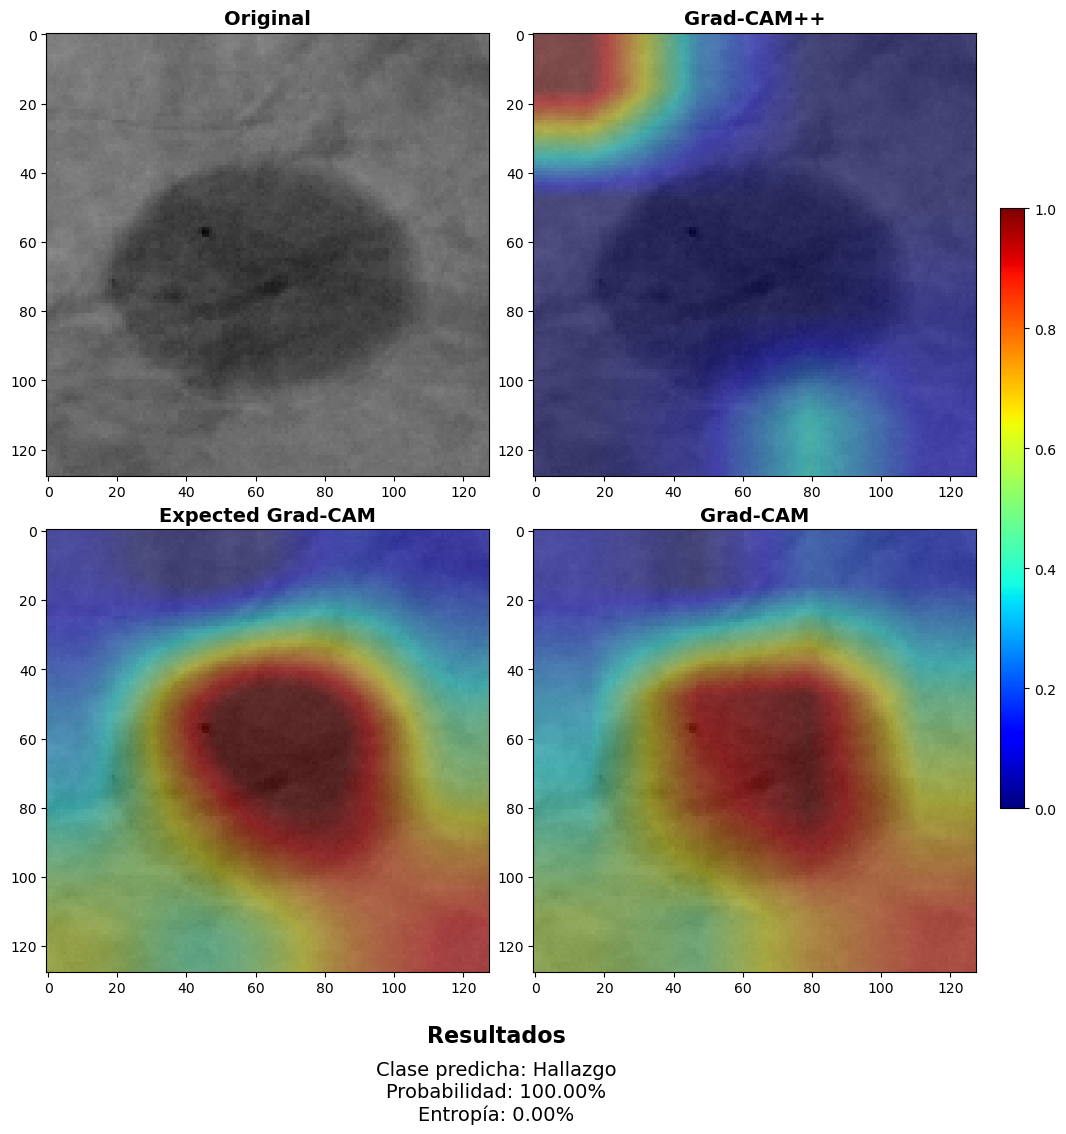

In [18]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"dbfffde4219dfb6aab1a5fe2d21a99d0_1_BI-RADS_4.png"
visualize_all_gradcam_methods(model, image_path)

# **Hallazgo Fragmentado**

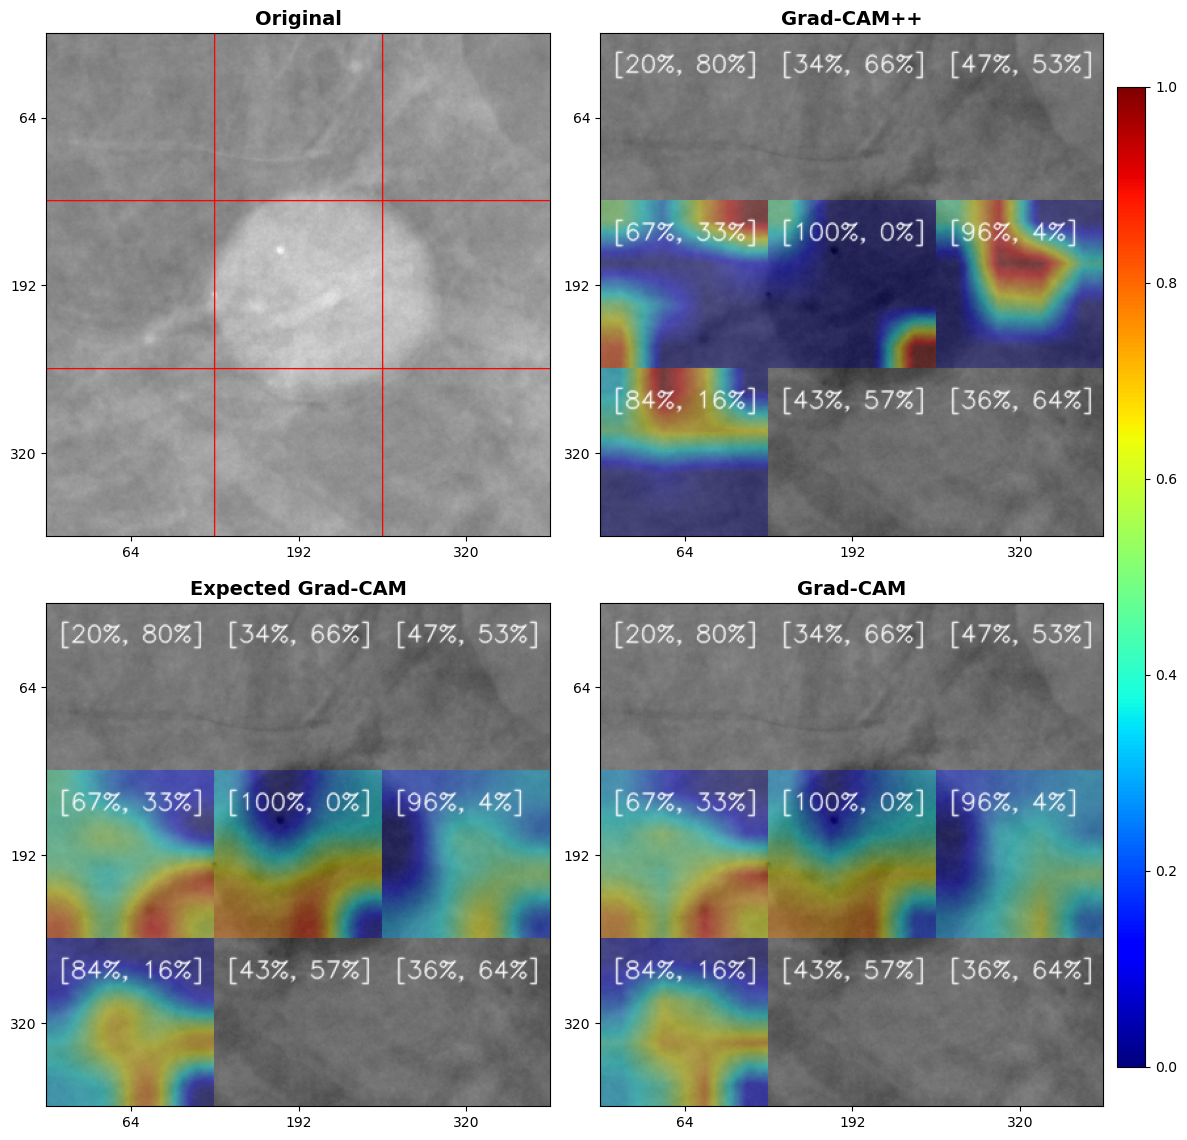

In [19]:
def visualize_combined_images_with_original_and_heatmaps(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name=layer_name):
    # Generar la imagen original combinada
    original_image = unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=True)

    # Generar imágenes combinadas usando Grad-CAM métodos
    combined_images = visualize_combined_methods(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name)

    # Crear figura con 2x2 para mostrar todas las imágenes
    fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # Figura 2x2
    titles = ['Original', 'Grad-CAM++', 'Expected Grad-CAM', 'Grad-CAM']
    images = [original_image, combined_images[2], combined_images[0], combined_images[1]]  # Orden de imágenes

    # Añadir cada imagen a la figura
    for ax, img, title in zip(axs.flat, images, titles):
        im = ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        # Configurar los ticks de los ejes
        img_height, img_width, _ = img.shape
        x_ticks = np.arange(64, img_width, 128)
        y_ticks = np.arange(64, img_height, 128)

        # Asegurarse de incluir marcas en 64 si no están
        if img_width >= 64 and 64 not in x_ticks:
            x_ticks = np.append(64, x_ticks)
        if img_height >= 64 and 64 not in y_ticks:
            y_ticks = np.append(64, y_ticks)

        # Aplicar los ticks a los ejes
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.axis("on")  # Mantener los ejes visibles

    # Añadir barra de calor común para los mapas de Grad-CAM
    cbar_ax = fig.add_axes([0.89, 0.16, 0.02, 0.7])  # Barra vertical ajustada
    plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), cax=cbar_ax)

    # Ajustar márgenes de la figura
    fig.subplots_adjust(top=0.92, right=0.88, wspace=0.1, hspace=0.01)
    
    plt.show()

# Modificar la función `unir_fragmentos_y_mostrar` para devolver la imagen en lugar de mostrarla
def unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=False):
    # Crear una imagen vacía para la imagen final
    final_image = np.zeros((fragment_size[0] * num_rows, fragment_size[1] * num_cols, 3), dtype=np.uint8)
    
    # Iterar sobre los fragmentos y colocarlos en la imagen final
    for i, num in enumerate(range(1, num_rows * num_cols + 1)):
        # Buscar el archivo correspondiente al fragmento
        fragment_path = os.path.join(fragment_dir, f"dbfffde4219dfb6aab1a5fe2d21a99d0_{num}.png")
        if not os.path.exists(fragment_path):
            print(f"Fragmento {num} no encontrado. Se omitirá.")
            continue

        # Leer el fragmento
        fragment = cv2.imread(fragment_path)
        if fragment is None:
            print(f"Error al cargar el fragmento {num}. Se omitirá.")
            continue

        # Redimensionar el fragmento para asegurar consistencia
        fragment = cv2.resize(fragment, (fragment_size[1], fragment_size[0]))

        # Calcular la posición en la imagen final
        row = i // num_cols
        col = i % num_cols
        y_start = row * fragment_size[0]
        y_end = y_start + fragment_size[0]
        x_start = col * fragment_size[1]
        x_end = x_start + fragment_size[1]

        # Colocar el fragmento en la posición correspondiente
        final_image[y_start:y_end, x_start:x_end] = fragment

    # Dibujar líneas divisorias rojas entre los fragmentos
    for row in range(1, num_rows):
        y = row * fragment_size[0]
        cv2.line(final_image, (0, y), (final_image.shape[1], y), (0, 0, 255), 1)  # Línea horizontal roja

    for col in range(1, num_cols):
        x = col * fragment_size[1]
        cv2.line(final_image, (x, 0), (x, final_image.shape[0]), (0, 0, 255), 1)  # Línea vertical roja

    if return_image:
        return final_image
    else:
        # Mostrar la imagen final
        plt.figure(figsize=(28, 16))
        plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
        plt.title("Original", fontsize=25, fontweight='bold')
        plt.axis("on")
        plt.show()

# Parámetros de ejemplo
fragment_dir = 'fragmentos_3'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 3  # Define el número de filas en la imagen final
num_cols = 3  # Define el número de columnas en la imagen final

# Visualizar las imágenes combinadas con el modelo y métodos Grad-CAM
visualize_combined_images_with_original_and_heatmaps(model, fragment_dir, fragment_size, num_rows, num_cols)

# **Mamografía**

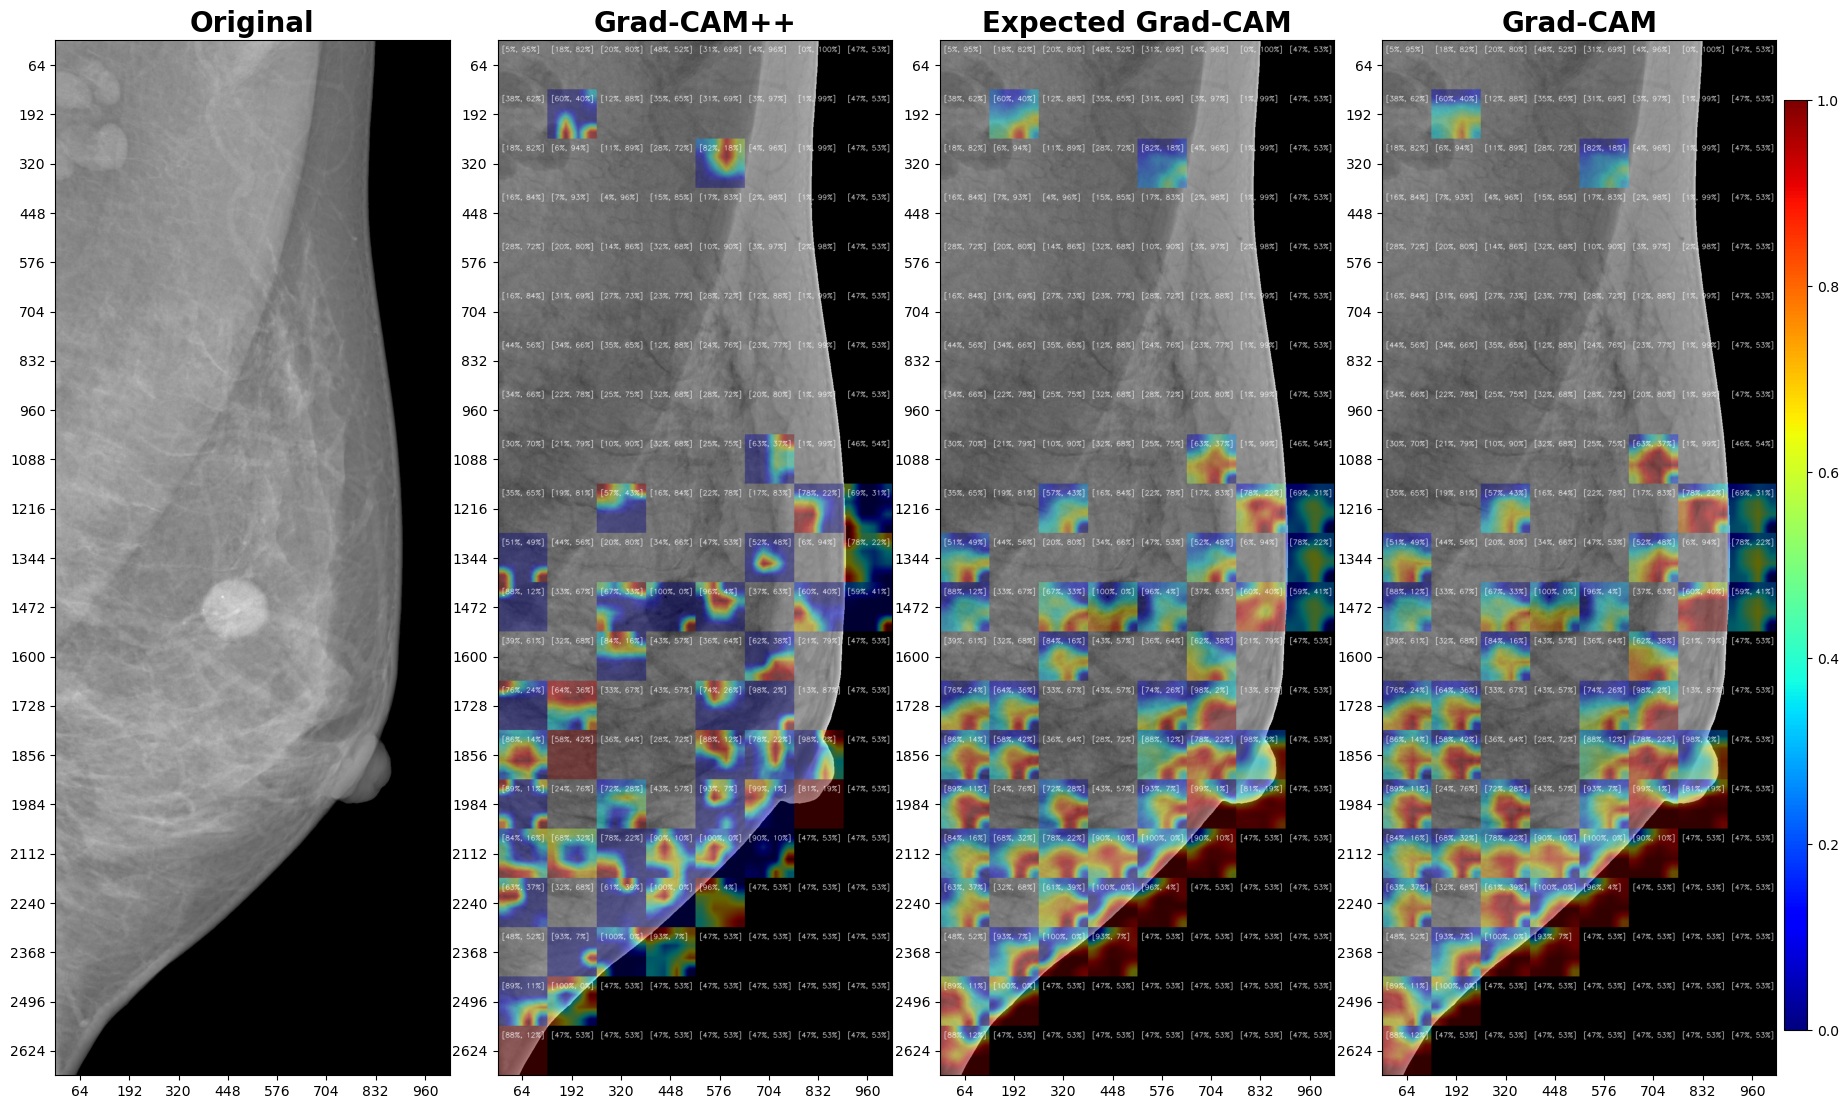

In [20]:
def visualize_combined_images_horizontal(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name=layer_name):
    # Generar la imagen original combinada
    original_image = unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=True)

    # Generar imágenes combinadas usando Grad-CAM métodos
    combined_images = visualize_combined_methods(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name)

    # Crear figura con 1x4 para mostrar todas las imágenes horizontalmente
    fig, axs = plt.subplots(1, 4, figsize=(23, 15))  # Figura 1x4
    titles = ['Original', 'Grad-CAM++', 'Expected Grad-CAM', 'Grad-CAM']
    # Reordenar las imágenes según la secuencia requerida
    images = [original_image, combined_images[2], combined_images[0], combined_images[1]]

    # Añadir cada imagen a la figura
    for ax, img, title in zip(axs, images, titles):
        im = ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title, fontsize=20, fontweight='bold')
        
        # Configurar los ticks de los ejes
        img_height, img_width, _ = img.shape
        x_ticks = np.arange(64, img_width, 128)
        y_ticks = np.arange(64, img_height, 128)

        # Asegurarse de incluir marcas en 64 si no están
        if img_width >= 64 and 64 not in x_ticks:
            x_ticks = np.append(64, x_ticks)
        if img_height >= 64 and 64 not in y_ticks:
            y_ticks = np.append(64, y_ticks)

        # Aplicar los ticks a los ejes
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.axis("on")  # Mantener los ejes visibles

    # Añadir barra de calor común para los mapas de Grad-CAM
    cbar_ax = fig.add_axes([0.88, 0.14, 0.01, 0.62])  # Barra vertical ajustada
    plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), cax=cbar_ax)

    # Ajustar márgenes de la figura
    fig.subplots_adjust(top=0.8, right=0.88, wspace=0.08)
    
    plt.show()

# Modificar la función `unir_fragmentos_y_mostrar` para devolver la imagen en lugar de mostrarla
def unir_fragmentos_y_mostrar(fragment_dir, fragment_size, num_rows, num_cols, return_image=False):
    # Crear una imagen vacía para la imagen final
    final_image = np.zeros((fragment_size[0] * num_rows, fragment_size[1] * num_cols, 3), dtype=np.uint8)
    
    # Iterar sobre los fragmentos y colocarlos en la imagen final
    for i, num in enumerate(range(1, num_rows * num_cols + 1)):
        # Buscar el archivo correspondiente al fragmento
        fragment_path = os.path.join(fragment_dir, f"dbfffde4219dfb6aab1a5fe2d21a99d0_{num}.png")
        if not os.path.exists(fragment_path):
            print(f"Fragmento {num} no encontrado. Se omitirá.")
            continue

        # Leer el fragmento
        fragment = cv2.imread(fragment_path)
        if fragment is None:
            print(f"Error al cargar el fragmento {num}. Se omitirá.")
            continue

        # Redimensionar el fragmento para asegurar consistencia
        fragment = cv2.resize(fragment, (fragment_size[1], fragment_size[0]))

        # Calcular la posición en la imagen final
        row = i // num_cols
        col = i % num_cols
        y_start = row * fragment_size[0]
        y_end = y_start + fragment_size[0]
        x_start = col * fragment_size[1]
        x_end = x_start + fragment_size[1]

        # Colocar el fragmento en la posición correspondiente
        final_image[y_start:y_end, x_start:x_end] = fragment

    if return_image:
        return final_image
    else:
        # Mostrar la imagen final
        plt.figure(figsize=(34, 34))
        plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
        plt.title("Original", fontsize=25, fontweight='bold')
        plt.axis("on")
        plt.show()

# Parámetros de ejemplo
fragment_dir = 'fragmentos_4'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 21  # Define el número de filas en la imagen final
num_cols = 8  # Define el número de columnas en la imagen final

# Visualizar las imágenes combinadas horizontalmente
visualize_combined_images_horizontal(model, fragment_dir, fragment_size, num_rows, num_cols)